# Virtual Graph Data Analysis

Comprehensive analysis of synthetically generated network motif graphs for GNN interpretability experiments.

In [1]:
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm.notebook import tqdm

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Data Loading

Load all generated graphs from the data directory.

In [2]:
data_dir = Path('./data')

def load_graphs_from_directory(directory):
    graphs = []
    for pkl_file in sorted(directory.glob('*.pkl')):
        with open(pkl_file, 'rb') as f:
            graphs.append(pickle.load(f))
    return graphs

motif_types = ['feedforward_loop', 'feedback_loop', 'single_input_module', 'cascade']
single_motif_graphs = {}

for motif in motif_types:
    motif_dir = data_dir / 'single_motif_graphs' / motif
    if motif_dir.exists():
        single_motif_graphs[motif] = load_graphs_from_directory(motif_dir)
        print(f"Loaded {len(single_motif_graphs[motif])} {motif} graphs")

mixed_dir = data_dir / 'mixed_motif_graphs'
if mixed_dir.exists():
    mixed_motif_graphs = load_graphs_from_directory(mixed_dir)
    print(f"Loaded {len(mixed_motif_graphs)} mixed motif graphs")

Loaded 1000 feedforward_loop graphs
Loaded 1000 feedback_loop graphs
Loaded 1000 single_input_module graphs
Loaded 1000 cascade graphs
Loaded 1000 mixed motif graphs


## Overview Statistics

High-level summary of the generated graph dataset.

In [3]:
total_single = sum(len(graphs) for graphs in single_motif_graphs.values())
total_mixed = len(mixed_motif_graphs)

print(f"Total single-motif graphs: {total_single}")
print(f"Total mixed-motif graphs: {total_mixed}")
print(f"Total graphs: {total_single + total_mixed}")
print(f"\nMotif type distribution:")
for motif, graphs in single_motif_graphs.items():
    print(f"  {motif}: {len(graphs)} graphs")

Total single-motif graphs: 4000
Total mixed-motif graphs: 1000
Total graphs: 5000

Motif type distribution:
  feedforward_loop: 1000 graphs
  feedback_loop: 1000 graphs
  single_input_module: 1000 graphs
  cascade: 1000 graphs


## Utility Functions

Helper functions for extracting graph properties and running simulations.

In [4]:
def extract_graph_properties(G):
    W = nx.to_numpy_array(G, weight='weight')
    edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]
    
    return {
        'num_nodes': len(G.nodes()),
        'num_edges': len(G.edges()),
        'density': nx.density(G),
        'edge_weights': edge_weights,
        'mean_weight': np.mean(edge_weights) if edge_weights else 0,
        'std_weight': np.std(edge_weights) if edge_weights else 0,
        'positive_edges': sum(1 for w in edge_weights if w > 0),
        'negative_edges': sum(1 for w in edge_weights if w < 0),
        'in_degrees': dict(G.in_degree()),
        'out_degrees': dict(G.out_degree()),
    }

def simulate_expression(W, steps=50, gamma=0.15, noise_std=0.01, seed=42):
    rng = np.random.default_rng(seed)
    n_nodes = W.shape[0]
    x = rng.uniform(0, 1, size=n_nodes)
    trajectory = np.zeros((steps, n_nodes))
    trajectory[0] = x
    
    for t in range(1, steps):
        weighted_input = W @ x
        sigmoid_input = 1.0 / (1.0 + np.exp(-np.clip(weighted_input, -10, 10)))
        noise = rng.normal(0, noise_std, size=n_nodes)
        x = (1 - gamma) * x + gamma * sigmoid_input + noise
        x = np.clip(x, 0, 1)
        trajectory[t] = x
    
    return x, trajectory

# Single-Motif Graph Analysis

Detailed analysis of each motif type individually.

## Feedforward Loop Motif

Analysis of feedforward loop graphs (A→B, A→C, B→C).

In [5]:
motif = 'feedforward_loop'
graphs = single_motif_graphs[motif]

properties = [extract_graph_properties(G) for G in graphs[:1000]]

df = pd.DataFrame({
    'num_nodes': [p['num_nodes'] for p in properties],
    'num_edges': [p['num_edges'] for p in properties],
    'density': [p['density'] for p in properties],
    'mean_weight': [p['mean_weight'] for p in properties],
    'positive_edges': [p['positive_edges'] for p in properties],
    'negative_edges': [p['negative_edges'] for p in properties],
})

print(f"\n{motif.upper()} - Summary Statistics:")
print(df.describe())


FEEDFORWARD_LOOP - Summary Statistics:
         num_nodes  num_edges      density  mean_weight  positive_edges  \
count  1000.000000     1000.0  1000.000000  1000.000000     1000.000000   
mean      3.496000        3.0     0.376000    -0.027141        1.432000   
std       0.500234        0.0     0.125059     0.336838        0.885528   
min       3.000000        3.0     0.250000    -0.816491        0.000000   
25%       3.000000        3.0     0.250000    -0.270549        1.000000   
50%       3.000000        3.0     0.500000    -0.031442        1.000000   
75%       4.000000        3.0     0.500000     0.217332        2.000000   
max       4.000000        3.0     0.500000     0.977553        3.000000   

       negative_edges  
count     1000.000000  
mean         1.568000  
std          0.885528  
min          0.000000  
25%          1.000000  
50%          2.000000  
75%          2.000000  
max          3.000000  


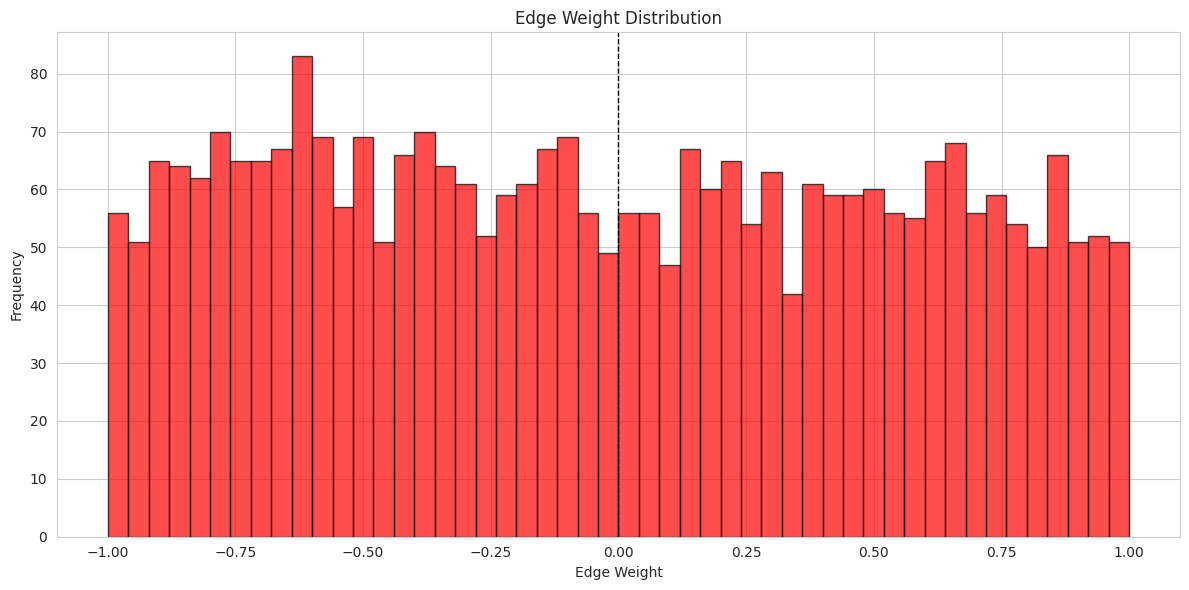

In [6]:
all_weights = [w for p in properties for w in p['edge_weights']]
plt.hist(all_weights, bins=50, edgecolor='black', alpha=0.7, color='red')
plt.xlabel('Edge Weight')
plt.ylabel('Frequency')
plt.title('Edge Weight Distribution')
plt.axvline(0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

/tmp/ipykernel_800171/1156502725.py:16: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors,


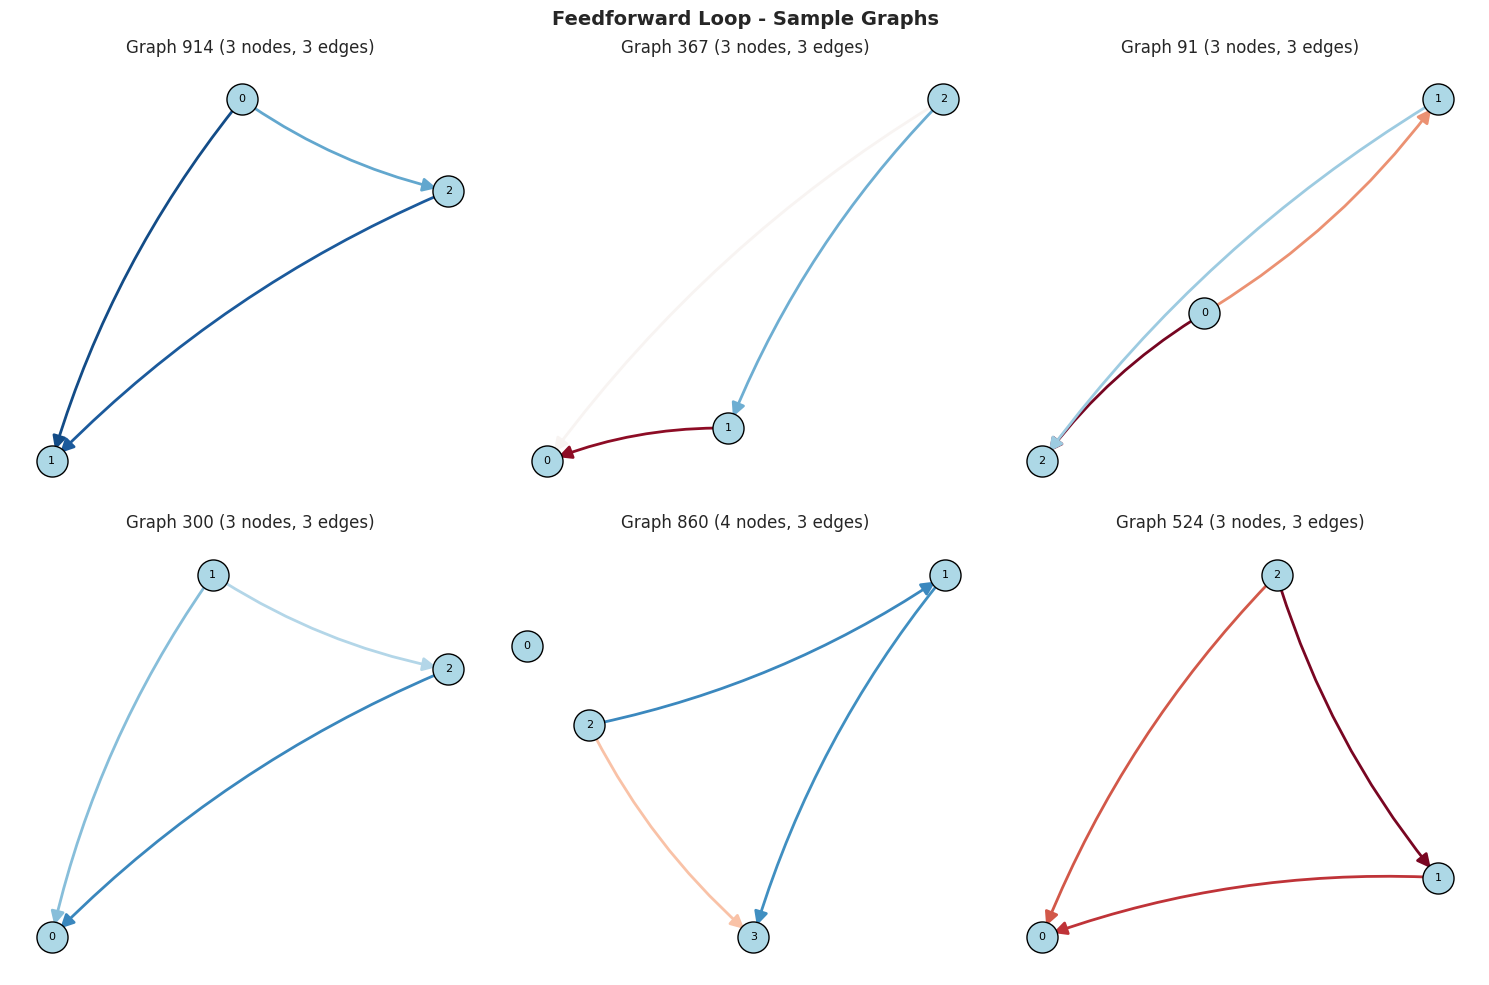

In [7]:
sample_graphs = np.random.choice(len(graphs), size=min(6, len(graphs)), replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, graph_idx in enumerate(sample_graphs):
    G = graphs[graph_idx]
    
    pos = nx.spring_layout(G, seed=42)
    
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', 
                          edgecolors='black', ax=axes[idx])
    
    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors, 
                                   edge_cmap=plt.cm.RdBu_r, edge_vmin=-1, edge_vmax=1,
                                   width=2, arrows=True, arrowsize=20, 
                                   connectionstyle='arc3,rad=0.1', ax=axes[idx])
    
    nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[idx])
    
    axes[idx].set_title(f'Graph {graph_idx} ({len(G.nodes())} nodes, {len(G.edges())} edges)')
    axes[idx].axis('off')

plt.suptitle(f'{motif.replace("_", " ").title()} - Sample Graphs', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

/tmp/ipykernel_800171/3832015435.py:18: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,


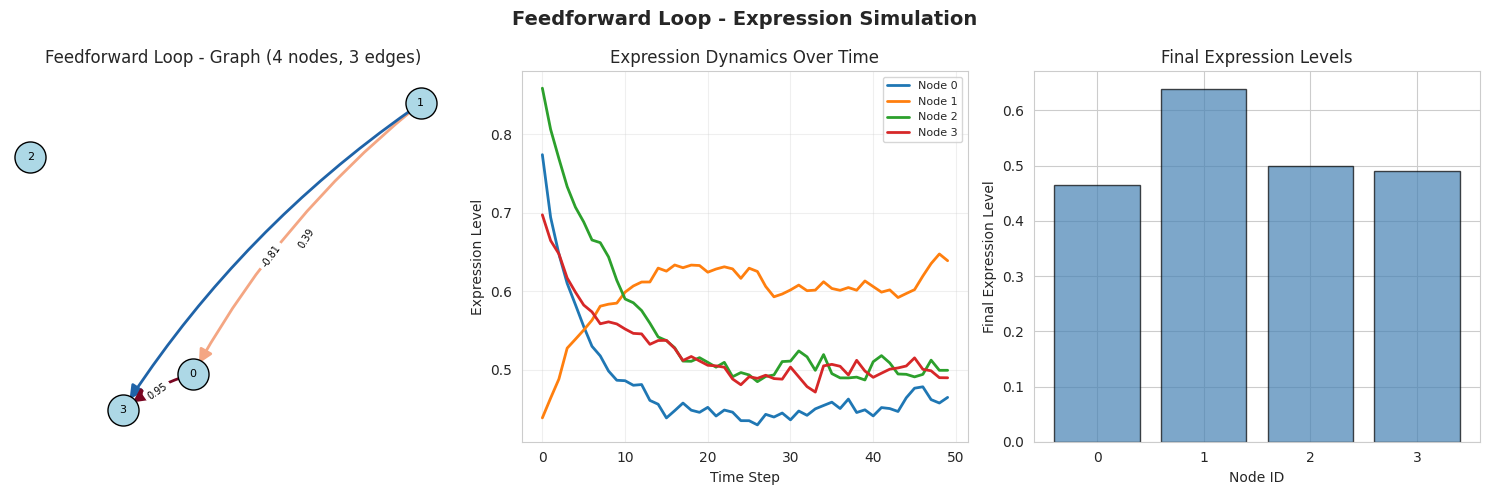

In [8]:
# draw the sample graph with edge weight labels and show expression simulation
sample_graph = graphs[0]
W = nx.to_numpy_array(sample_graph, weight='weight')
final_expr, trajectory = simulate_expression(W, steps=50)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

G = sample_graph
pos = nx.spring_layout(G, seed=42)

# node drawing
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue',
                       edgecolors='black', ax=axes[0])
nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[0])

# edges with colormap based on weight
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
                       edge_cmap=plt.cm.RdBu_r, edge_vmin=-1, edge_vmax=1,
                       width=2, arrows=True, arrowsize=20,
                       connectionstyle='arc3,rad=0.1', ax=axes[0])

# create and draw edge labels (formatted weights)
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7,
                             font_color='black', label_pos=0.5, ax=axes[0])

axes[0].set_title(f'{motif.replace("_", " ").title()} - Graph ({len(G.nodes())} nodes, {len(G.edges())} edges)')
axes[0].axis('off')

# expression dynamics
for node in range(len(final_expr)):
    axes[1].plot(trajectory[:, node], label=f'Node {node}', linewidth=2)
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Expression Level')
axes[1].set_title('Expression Dynamics Over Time')
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.3)

# final expression bar plot
axes[2].bar(range(len(final_expr)), final_expr, color='steelblue', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Node ID')
axes[2].set_ylabel('Final Expression Level')
axes[2].set_title('Final Expression Levels')
axes[2].set_xticks(range(len(final_expr)))

plt.suptitle(f'{motif.replace("_", " ").title()} - Expression Simulation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Feedback Loop Motif

Analysis of feedback loop graphs (X→Y, Y→X).

In [9]:
motif = 'feedback_loop'
graphs = single_motif_graphs[motif]

properties = [extract_graph_properties(G) for G in graphs[:1000]]

df = pd.DataFrame({
    'num_nodes': [p['num_nodes'] for p in properties],
    'num_edges': [p['num_edges'] for p in properties],
    'density': [p['density'] for p in properties],
    'mean_weight': [p['mean_weight'] for p in properties],
    'positive_edges': [p['positive_edges'] for p in properties],
    'negative_edges': [p['negative_edges'] for p in properties],
})

print(f"\n{motif.upper()} - Summary Statistics:")
print(df.describe())


FEEDBACK_LOOP - Summary Statistics:
         num_nodes  num_edges      density  mean_weight  positive_edges  \
count  1000.000000     1000.0  1000.000000  1000.000000     1000.000000   
mean      3.505000        2.0     0.249167    -0.002661        0.993000   
std       0.500225        0.0     0.083371     0.418405        0.712361   
min       3.000000        2.0     0.166667    -0.975447        0.000000   
25%       3.000000        2.0     0.166667    -0.293903        0.000000   
50%       4.000000        2.0     0.166667    -0.008664        1.000000   
75%       4.000000        2.0     0.333333     0.280054        1.250000   
max       4.000000        2.0     0.333333     0.928778        2.000000   

       negative_edges  
count     1000.000000  
mean         1.007000  
std          0.712361  
min          0.000000  
25%          0.750000  
50%          1.000000  
75%          2.000000  
max          2.000000  


/tmp/ipykernel_800171/1985618759.py:16: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors,


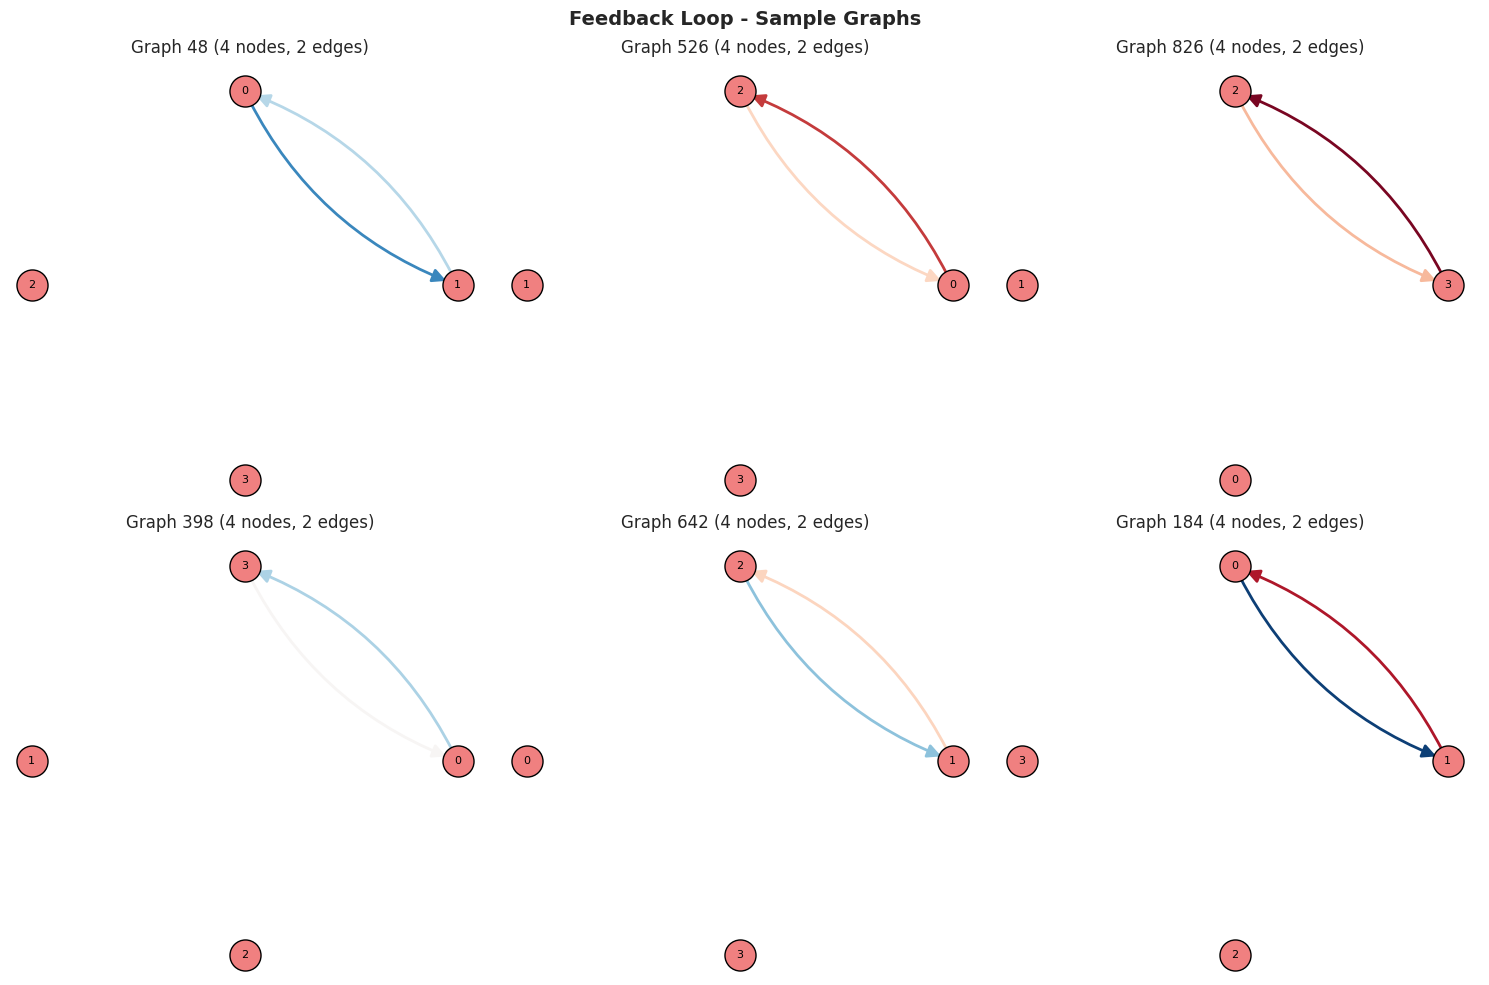

In [10]:
sample_graphs = np.random.choice(len(graphs), size=min(6, len(graphs)), replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, graph_idx in enumerate(sample_graphs):
    G = graphs[graph_idx]
    
    pos = nx.circular_layout(G)
    
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightcoral', 
                          edgecolors='black', ax=axes[idx])
    
    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors, 
                                   edge_cmap=plt.cm.RdBu_r, edge_vmin=-1, edge_vmax=1,
                                   width=2, arrows=True, arrowsize=20, 
                                   connectionstyle='arc3,rad=0.2', ax=axes[idx])
    
    nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[idx])
    
    axes[idx].set_title(f'Graph {graph_idx} ({len(G.nodes())} nodes, {len(G.edges())} edges)')
    axes[idx].axis('off')

plt.suptitle(f'{motif.replace("_", " ").title()} - Sample Graphs', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

/tmp/ipykernel_800171/3832015435.py:18: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,


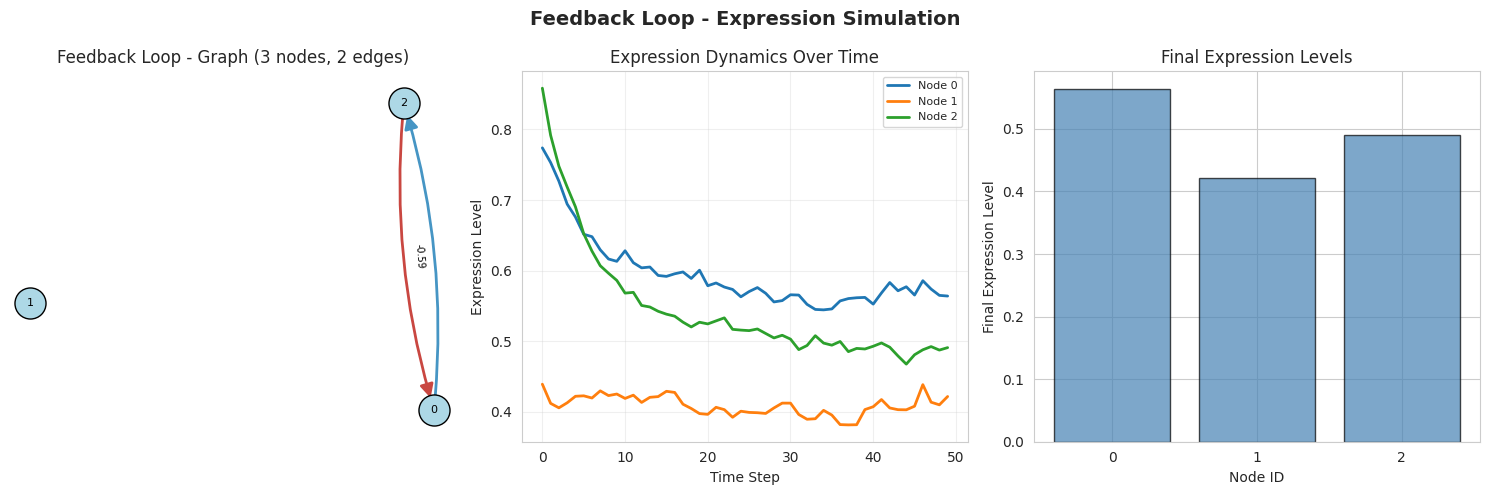

In [11]:
# draw the sample graph with edge weight labels and show expression simulation
sample_graph = graphs[0]
W = nx.to_numpy_array(sample_graph, weight='weight')
final_expr, trajectory = simulate_expression(W, steps=50)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

G = sample_graph
pos = nx.spring_layout(G, seed=42)

# node drawing
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue',
                       edgecolors='black', ax=axes[0])
nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[0])

# edges with colormap based on weight
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
                       edge_cmap=plt.cm.RdBu_r, edge_vmin=-1, edge_vmax=1,
                       width=2, arrows=True, arrowsize=20,
                       connectionstyle='arc3,rad=0.1', ax=axes[0])

# create and draw edge labels (formatted weights)
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7,
                             font_color='black', label_pos=0.5, ax=axes[0])

axes[0].set_title(f'{motif.replace("_", " ").title()} - Graph ({len(G.nodes())} nodes, {len(G.edges())} edges)')
axes[0].axis('off')

# expression dynamics
for node in range(len(final_expr)):
    axes[1].plot(trajectory[:, node], label=f'Node {node}', linewidth=2)
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Expression Level')
axes[1].set_title('Expression Dynamics Over Time')
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.3)

# final expression bar plot
axes[2].bar(range(len(final_expr)), final_expr, color='steelblue', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Node ID')
axes[2].set_ylabel('Final Expression Level')
axes[2].set_title('Final Expression Levels')
axes[2].set_xticks(range(len(final_expr)))

plt.suptitle(f'{motif.replace("_", " ").title()} - Expression Simulation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Single Input Module Motif

Analysis of single input module graphs (R→G1, R→G2, R→G3, R→G4).

In [12]:
motif = 'single_input_module'
graphs = single_motif_graphs[motif]

properties = [extract_graph_properties(G) for G in graphs[:1000]]

df = pd.DataFrame({
    'num_nodes': [p['num_nodes'] for p in properties],
    'num_edges': [p['num_edges'] for p in properties],
    'density': [p['density'] for p in properties],
    'mean_weight': [p['mean_weight'] for p in properties],
    'positive_edges': [p['positive_edges'] for p in properties],
    'negative_edges': [p['negative_edges'] for p in properties],
})

print(f"\n{motif.upper()} - Summary Statistics:")
print(df.describe())


SINGLE_INPUT_MODULE - Summary Statistics:
        num_nodes   num_edges      density  mean_weight  positive_edges  \
count  1000.00000  1000.00000  1000.000000  1000.000000     1000.000000   
mean      4.51000     3.51000     0.224500    -0.008009        1.730000   
std       0.50015     0.50015     0.025008     0.311509        0.983905   
min       4.00000     3.00000     0.200000    -0.857626        0.000000   
25%       4.00000     3.00000     0.200000    -0.234589        1.000000   
50%       5.00000     4.00000     0.200000    -0.005309        2.000000   
75%       5.00000     4.00000     0.250000     0.215072        2.000000   
max       5.00000     4.00000     0.250000     0.873943        4.000000   

       negative_edges  
count     1000.000000  
mean         1.780000  
std          0.974962  
min          0.000000  
25%          1.000000  
50%          2.000000  
75%          2.000000  
max          4.000000  


/tmp/ipykernel_800171/754935315.py:16: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors,


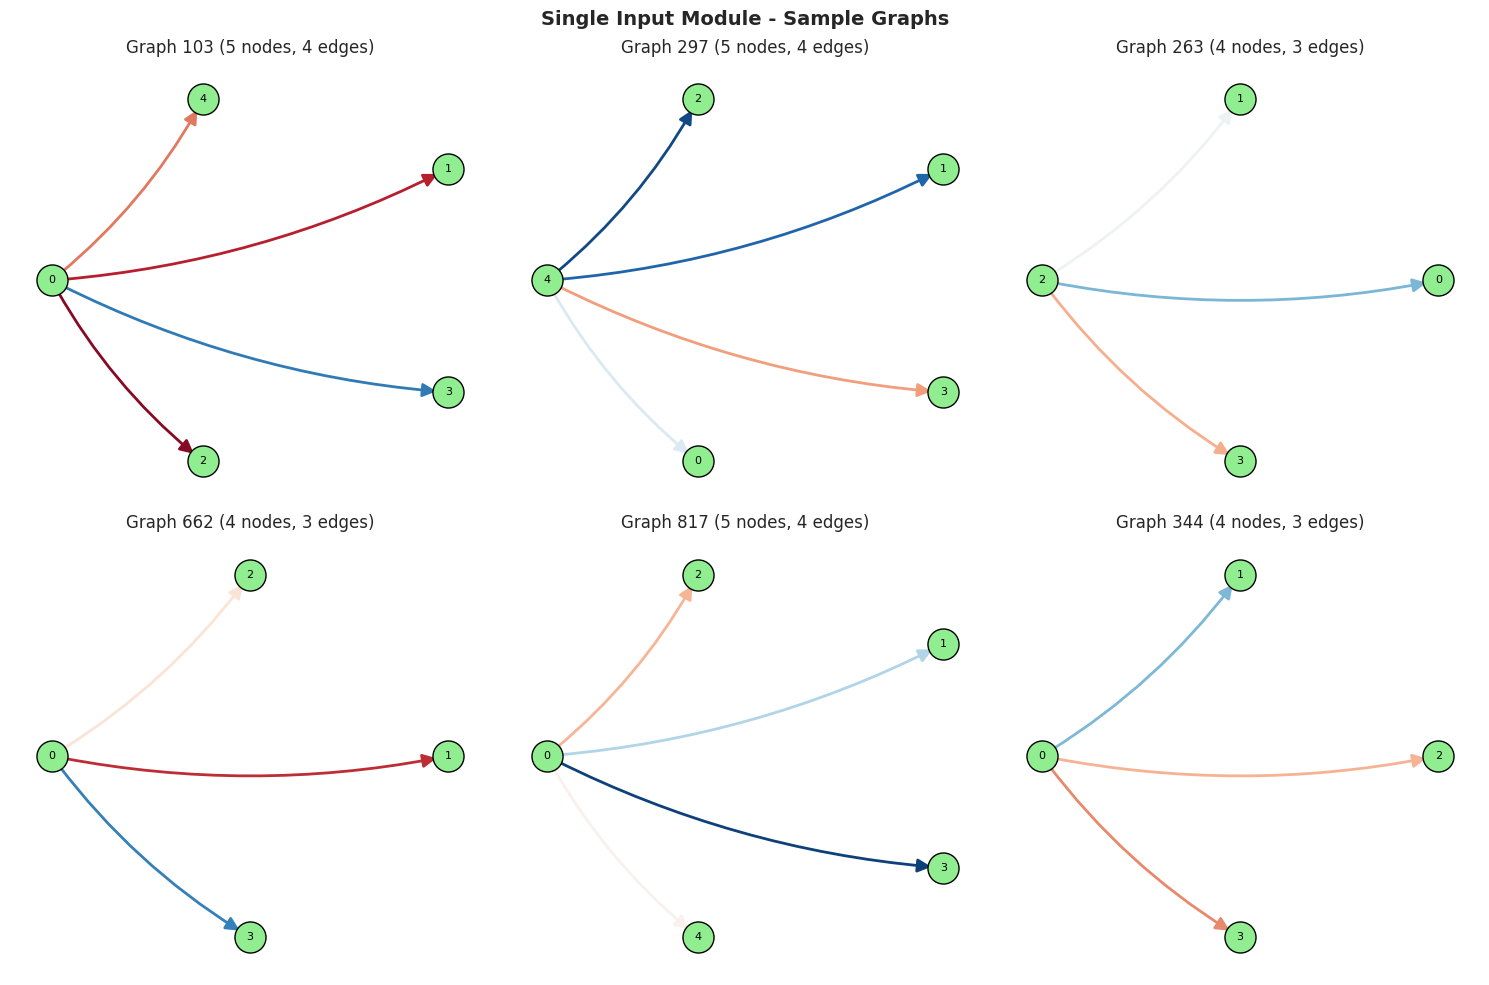

In [13]:
sample_graphs = np.random.choice(len(graphs), size=min(6, len(graphs)), replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, graph_idx in enumerate(sample_graphs):
    G = graphs[graph_idx]
    
    pos = nx.shell_layout(G)
    
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgreen', 
                          edgecolors='black', ax=axes[idx])
    
    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors, 
                                   edge_cmap=plt.cm.RdBu_r, edge_vmin=-1, edge_vmax=1,
                                   width=2, arrows=True, arrowsize=20, 
                                   connectionstyle='arc3,rad=0.1', ax=axes[idx])
    
    nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[idx])
    
    axes[idx].set_title(f'Graph {graph_idx} ({len(G.nodes())} nodes, {len(G.edges())} edges)')
    axes[idx].axis('off')

plt.suptitle(f'{motif.replace("_", " ").title()} - Sample Graphs', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

/tmp/ipykernel_800171/3832015435.py:18: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,


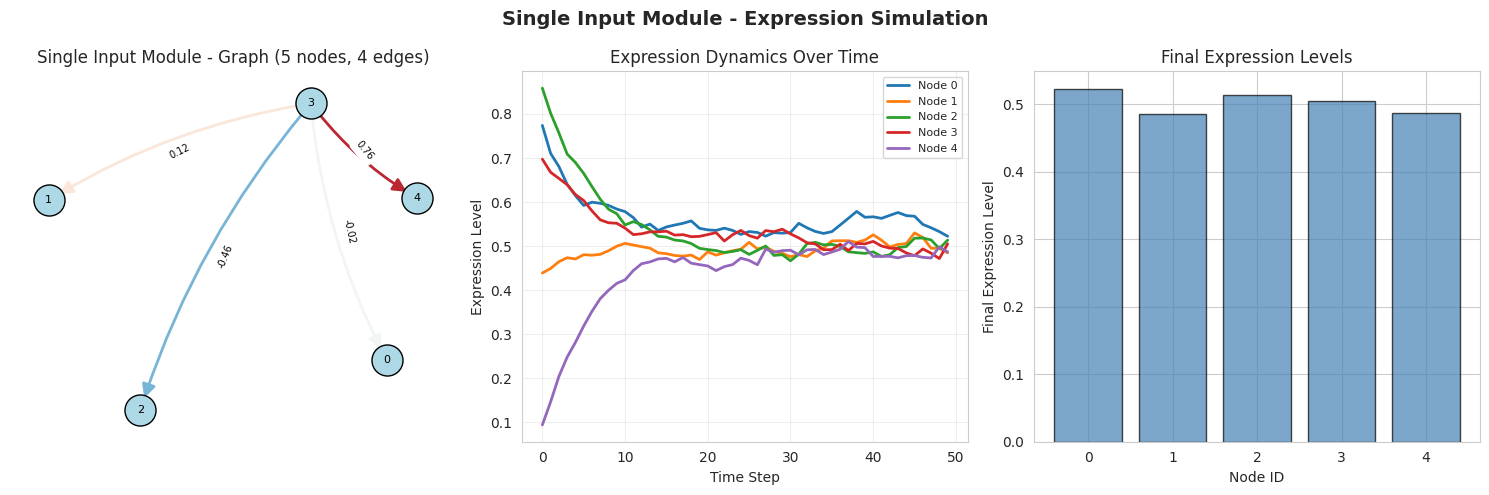

In [14]:
# draw the sample graph with edge weight labels and show expression simulation
sample_graph = graphs[0]
W = nx.to_numpy_array(sample_graph, weight='weight')
final_expr, trajectory = simulate_expression(W, steps=50)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

G = sample_graph
pos = nx.spring_layout(G, seed=42)

# node drawing
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue',
                       edgecolors='black', ax=axes[0])
nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[0])

# edges with colormap based on weight
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
                       edge_cmap=plt.cm.RdBu_r, edge_vmin=-1, edge_vmax=1,
                       width=2, arrows=True, arrowsize=20,
                       connectionstyle='arc3,rad=0.1', ax=axes[0])

# create and draw edge labels (formatted weights)
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7,
                             font_color='black', label_pos=0.5, ax=axes[0])

axes[0].set_title(f'{motif.replace("_", " ").title()} - Graph ({len(G.nodes())} nodes, {len(G.edges())} edges)')
axes[0].axis('off')

# expression dynamics
for node in range(len(final_expr)):
    axes[1].plot(trajectory[:, node], label=f'Node {node}', linewidth=2)
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Expression Level')
axes[1].set_title('Expression Dynamics Over Time')
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.3)

# final expression bar plot
axes[2].bar(range(len(final_expr)), final_expr, color='steelblue', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Node ID')
axes[2].set_ylabel('Final Expression Level')
axes[2].set_title('Final Expression Levels')
axes[2].set_xticks(range(len(final_expr)))

plt.suptitle(f'{motif.replace("_", " ").title()} - Expression Simulation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [15]:
G.edges(data=True)

OutEdgeDataView([(3, 0, {'weight': -0.02474057487817949}), (3, 2, {'weight': -0.4611265775492719}), (3, 1, {'weight': 0.12127298941681275}), (3, 4, {'weight': 0.756829332890343})])

## Cascade Motif

Analysis of cascade graphs (A→B→C→D).

In [16]:
motif = 'cascade'
graphs = single_motif_graphs[motif]

properties = [extract_graph_properties(G) for G in graphs[:1000]]

df = pd.DataFrame({
    'num_nodes': [p['num_nodes'] for p in properties],
    'num_edges': [p['num_edges'] for p in properties],
    'density': [p['density'] for p in properties],
    'mean_weight': [p['mean_weight'] for p in properties],
    'positive_edges': [p['positive_edges'] for p in properties],
    'negative_edges': [p['negative_edges'] for p in properties],
})

print(f"\n{motif.upper()} - Summary Statistics:")
print(df.describe())


CASCADE - Summary Statistics:
       num_nodes  num_edges  density  mean_weight  positive_edges  \
count     1000.0     1000.0  1000.00  1000.000000     1000.000000   
mean         4.0        3.0     0.25     0.005743        1.512000   
std          0.0        0.0     0.00     0.330603        0.836993   
min          4.0        3.0     0.25    -0.944442        0.000000   
25%          4.0        3.0     0.25    -0.215258        1.000000   
50%          4.0        3.0     0.25     0.015351        2.000000   
75%          4.0        3.0     0.25     0.237575        2.000000   
max          4.0        3.0     0.25     0.844308        3.000000   

       negative_edges  
count     1000.000000  
mean         1.488000  
std          0.836993  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          2.000000  
max          3.000000  


/tmp/ipykernel_800171/3159852952.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors,


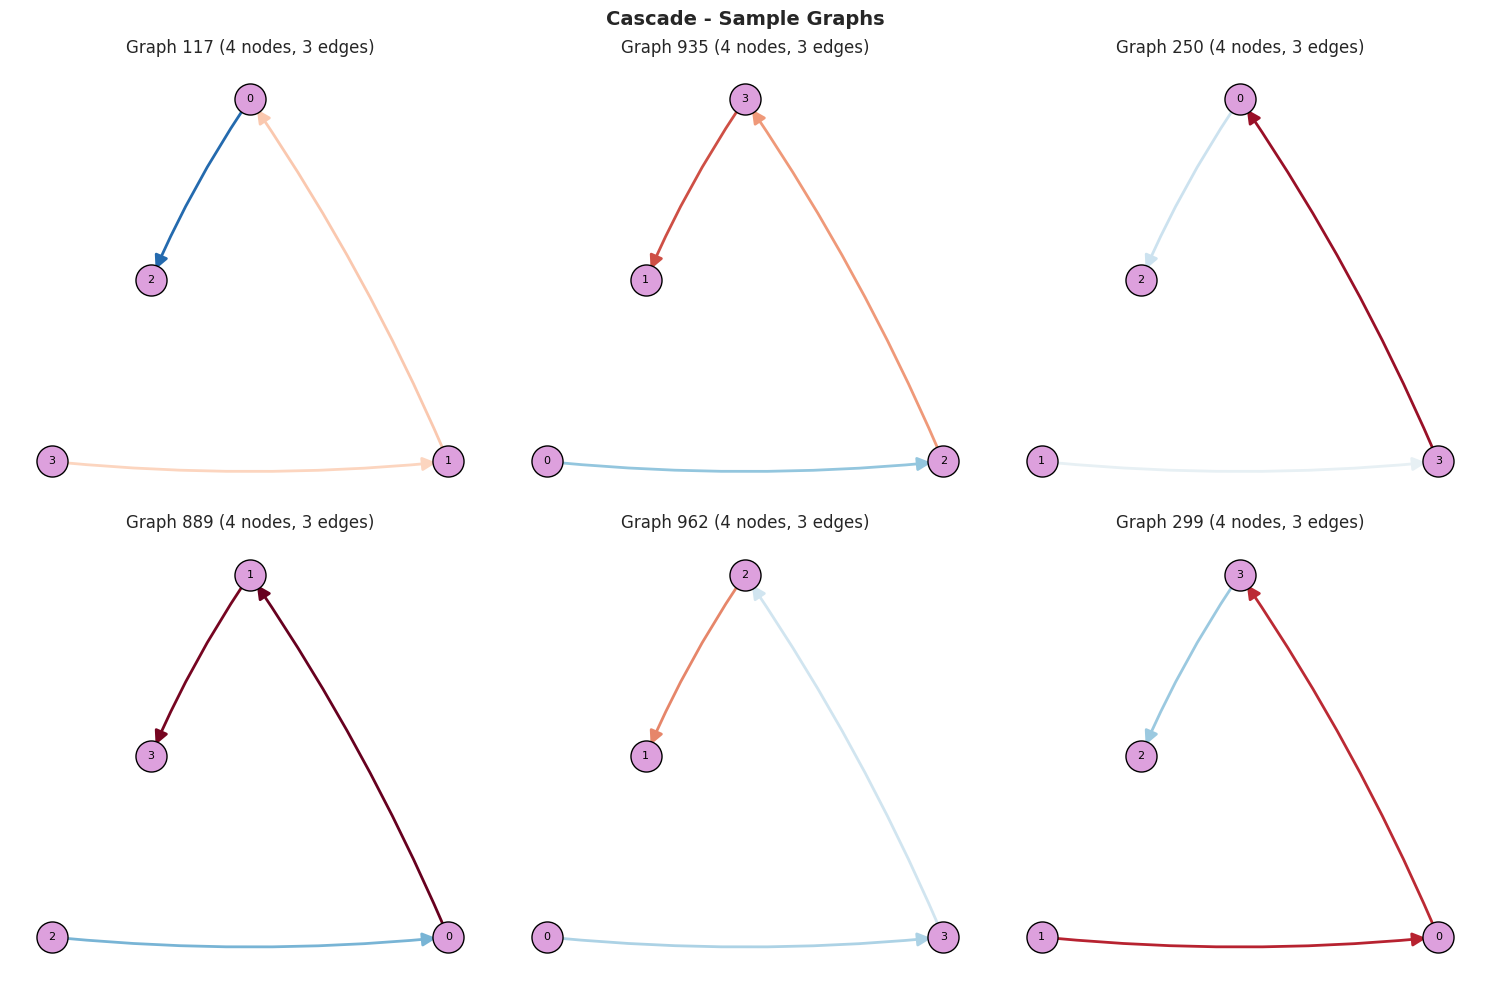

In [17]:
sample_graphs = np.random.choice(len(graphs), size=min(6, len(graphs)), replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, graph_idx in enumerate(sample_graphs):
    G = graphs[graph_idx]
    
    try:
        pos = nx.planar_layout(G)
    except:
        pos = nx.spring_layout(G, seed=42)
    
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='plum', 
                          edgecolors='black', ax=axes[idx])
    
    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors, 
                                   edge_cmap=plt.cm.RdBu_r, edge_vmin=-1, edge_vmax=1,
                                   width=2, arrows=True, arrowsize=20, 
                                   connectionstyle='arc3,rad=0.05', ax=axes[idx])
    
    nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[idx])
    
    axes[idx].set_title(f'Graph {graph_idx} ({len(G.nodes())} nodes, {len(G.edges())} edges)')
    axes[idx].axis('off')

plt.suptitle(f'{motif.replace("_", " ").title()} - Sample Graphs', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

/tmp/ipykernel_800171/3832015435.py:18: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors,


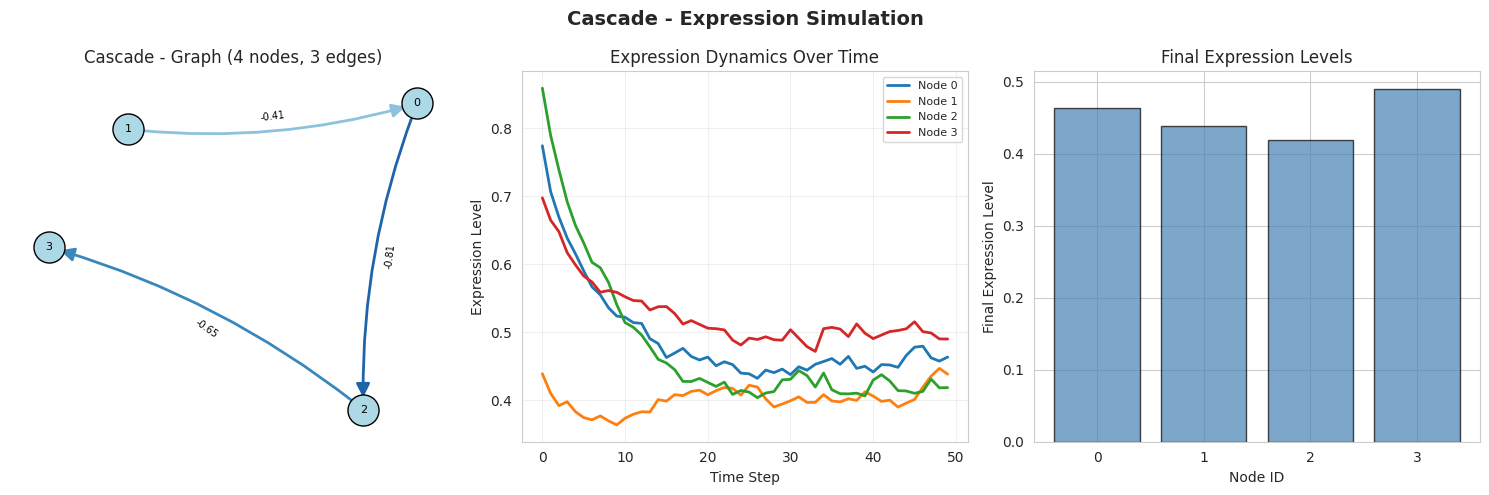

In [18]:
# draw the sample graph with edge weight labels and show expression simulation
sample_graph = graphs[0]
W = nx.to_numpy_array(sample_graph, weight='weight')
final_expr, trajectory = simulate_expression(W, steps=50)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

G = sample_graph
pos = nx.spring_layout(G, seed=42)

# node drawing
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue',
                       edgecolors='black', ax=axes[0])
nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[0])

# edges with colormap based on weight
edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
                       edge_cmap=plt.cm.RdBu_r, edge_vmin=-1, edge_vmax=1,
                       width=2, arrows=True, arrowsize=20,
                       connectionstyle='arc3,rad=0.1', ax=axes[0])

# create and draw edge labels (formatted weights)
edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7,
                             font_color='black', label_pos=0.5, ax=axes[0])

axes[0].set_title(f'{motif.replace("_", " ").title()} - Graph ({len(G.nodes())} nodes, {len(G.edges())} edges)')
axes[0].axis('off')

# expression dynamics
for node in range(len(final_expr)):
    axes[1].plot(trajectory[:, node], label=f'Node {node}', linewidth=2)
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Expression Level')
axes[1].set_title('Expression Dynamics Over Time')
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.3)

# final expression bar plot
axes[2].bar(range(len(final_expr)), final_expr, color='steelblue', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Node ID')
axes[2].set_ylabel('Final Expression Level')
axes[2].set_title('Final Expression Levels')
axes[2].set_xticks(range(len(final_expr)))

plt.suptitle(f'{motif.replace("_", " ").title()} - Expression Simulation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Cross-Motif Comparison

Compare properties across all single-motif graph types.

In [19]:
comparison_data = []

for motif_name, graphs in single_motif_graphs.items():
    for G in graphs[:500]:
        props = extract_graph_properties(G)
        comparison_data.append({
            'motif': motif_name,
            'num_nodes': props['num_nodes'],
            'num_edges': props['num_edges'],
            'density': props['density'],
            'mean_weight': props['mean_weight'],
            'std_weight': props['std_weight'],
            'positive_ratio': props['positive_edges'] / max(props['num_edges'], 1)
        })

comparison_df = pd.DataFrame(comparison_data)

/tmp/ipykernel_800171/2616106436.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_800171/2616106436.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_800171/2616106436.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 2].set_xticklabels(axes[0, 2].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_800171/2616106436.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='ri

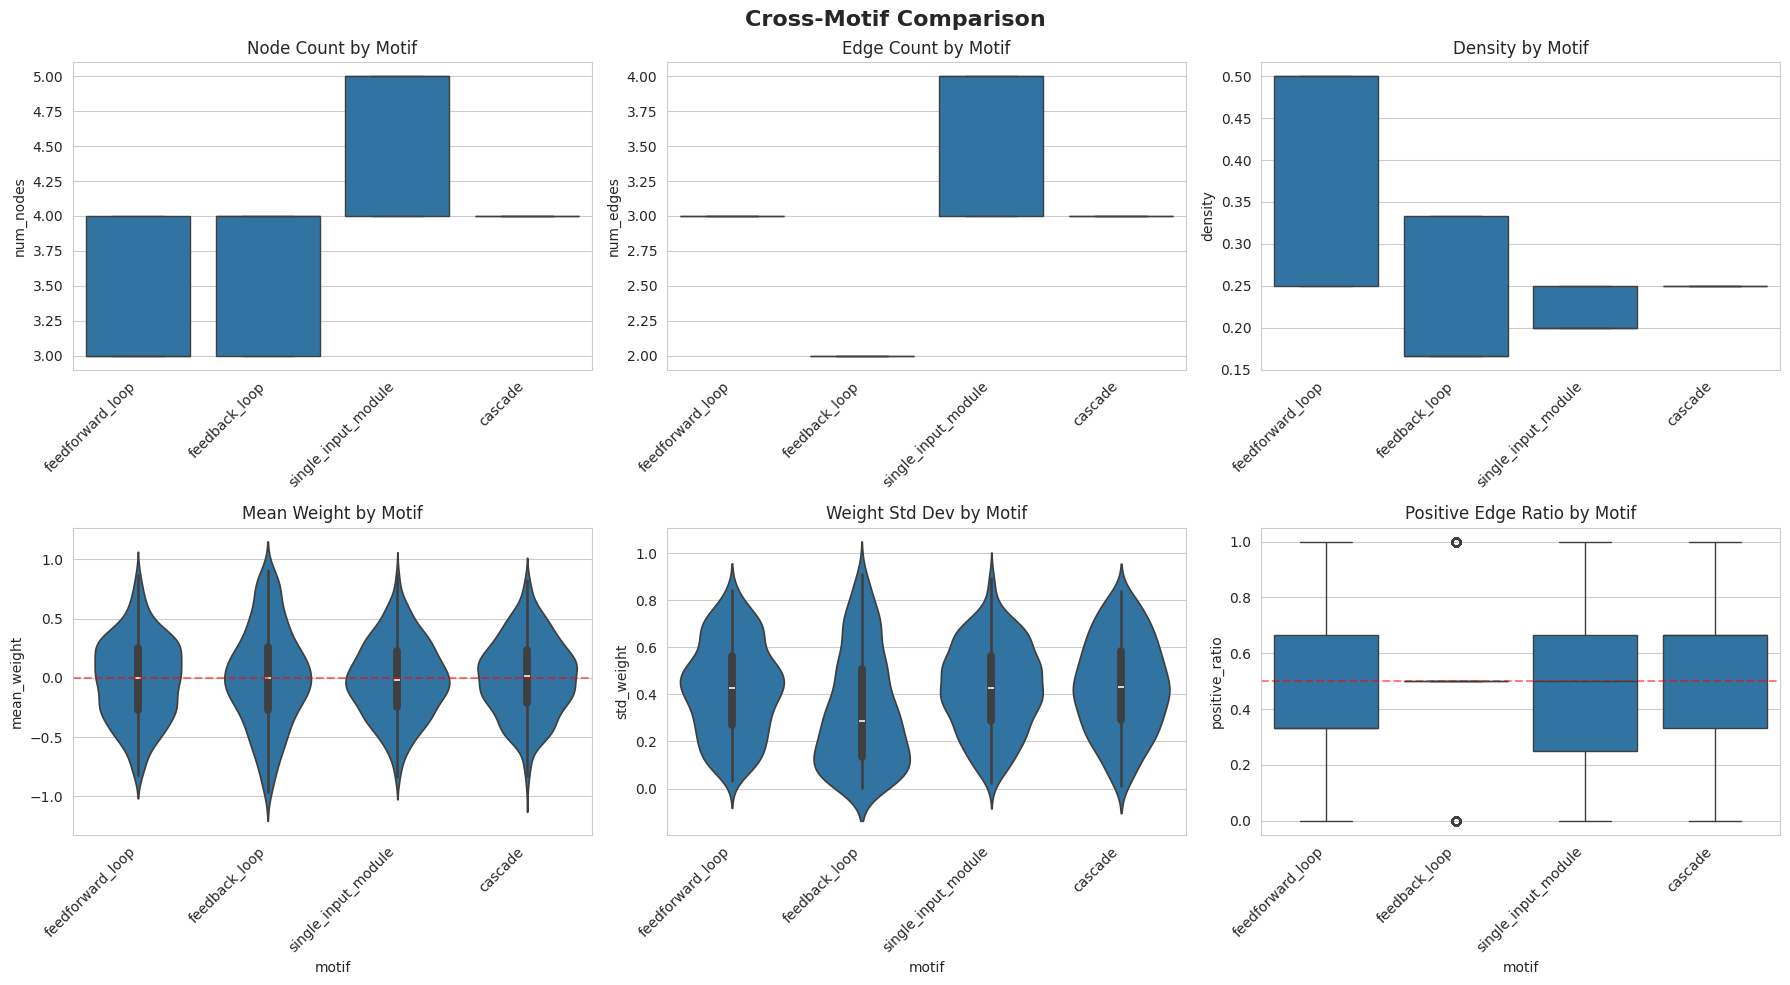

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.boxplot(data=comparison_df, x='motif', y='num_nodes', ax=axes[0, 0])
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
axes[0, 0].set_title('Node Count by Motif')
axes[0, 0].set_xlabel('')

sns.boxplot(data=comparison_df, x='motif', y='num_edges', ax=axes[0, 1])
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
axes[0, 1].set_title('Edge Count by Motif')
axes[0, 1].set_xlabel('')

sns.boxplot(data=comparison_df, x='motif', y='density', ax=axes[0, 2])
axes[0, 2].set_xticklabels(axes[0, 2].get_xticklabels(), rotation=45, ha='right')
axes[0, 2].set_title('Density by Motif')
axes[0, 2].set_xlabel('')

sns.violinplot(data=comparison_df, x='motif', y='mean_weight', ax=axes[1, 0])
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
axes[1, 0].set_title('Mean Weight by Motif')
axes[1, 0].axhline(0, color='red', linestyle='--', alpha=0.5)

sns.violinplot(data=comparison_df, x='motif', y='std_weight', ax=axes[1, 1])
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
axes[1, 1].set_title('Weight Std Dev by Motif')

sns.boxplot(data=comparison_df, x='motif', y='positive_ratio', ax=axes[1, 2])
axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), rotation=45, ha='right')
axes[1, 2].set_title('Positive Edge Ratio by Motif')
axes[1, 2].axhline(0.5, color='red', linestyle='--', alpha=0.5)

plt.suptitle('Cross-Motif Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [21]:
print("\nCross-Motif Statistics Summary:")
print(comparison_df.groupby('motif').agg({
    'num_nodes': ['mean', 'std'],
    'num_edges': ['mean', 'std'],
    'density': ['mean', 'std'],
    'mean_weight': ['mean', 'std'],
    'positive_ratio': ['mean', 'std']
}).round(4))


Cross-Motif Statistics Summary:
                    num_nodes         num_edges         density          \
                         mean     std      mean     std    mean     std   
motif                                                                     
cascade                 4.000  0.0000     3.000  0.0000  0.2500  0.0000   
feedback_loop           3.528  0.4997     2.000  0.0000  0.2453  0.0833   
feedforward_loop        3.488  0.5004     3.000  0.0000  0.3780  0.1251   
single_input_module     4.536  0.4992     3.536  0.4992  0.2232  0.0250   

                    mean_weight         positive_ratio          
                           mean     std           mean     std  
motif                                                           
cascade                  0.0039  0.3217         0.5000  0.2804  
feedback_loop            0.0062  0.4147         0.5040  0.3482  
feedforward_loop        -0.0169  0.3452         0.4833  0.2916  
single_input_module     -0.0140  0.3222         0.4

---
# Mixed-Motif Graph Analysis

Analysis of graphs containing multiple motifs.

In [22]:
mixed_properties = [extract_graph_properties(G) for G in mixed_motif_graphs[:1000]]

mixed_df = pd.DataFrame({
    'num_nodes': [p['num_nodes'] for p in mixed_properties],
    'num_edges': [p['num_edges'] for p in mixed_properties],
    'density': [p['density'] for p in mixed_properties],
    'mean_weight': [p['mean_weight'] for p in mixed_properties],
    'positive_edges': [p['positive_edges'] for p in mixed_properties],
    'negative_edges': [p['negative_edges'] for p in mixed_properties],
})

print("MIXED MOTIF GRAPHS - Summary Statistics:")
print(mixed_df.describe())

MIXED MOTIF GRAPHS - Summary Statistics:
         num_nodes    num_edges      density  mean_weight  positive_edges  \
count  1000.000000  1000.000000  1000.000000  1000.000000     1000.000000   
mean     10.574000    31.173000     0.303308    -0.000620       15.555000   
std       1.733069    10.597423     0.054115     0.107844        5.870386   
min       6.000000     9.000000     0.163636    -0.345642        2.000000   
25%       9.000000    23.000000     0.265152    -0.066159       11.000000   
50%      11.000000    31.000000     0.301282    -0.002683       15.000000   
75%      12.000000    39.000000     0.336364     0.066586       19.000000   
max      14.000000    64.000000     0.523810     0.398389       35.000000   

       negative_edges  
count     1000.000000  
mean        15.618000  
std          6.090416  
min          2.000000  
25%         11.000000  
50%         15.000000  
75%         20.000000  
max         36.000000  


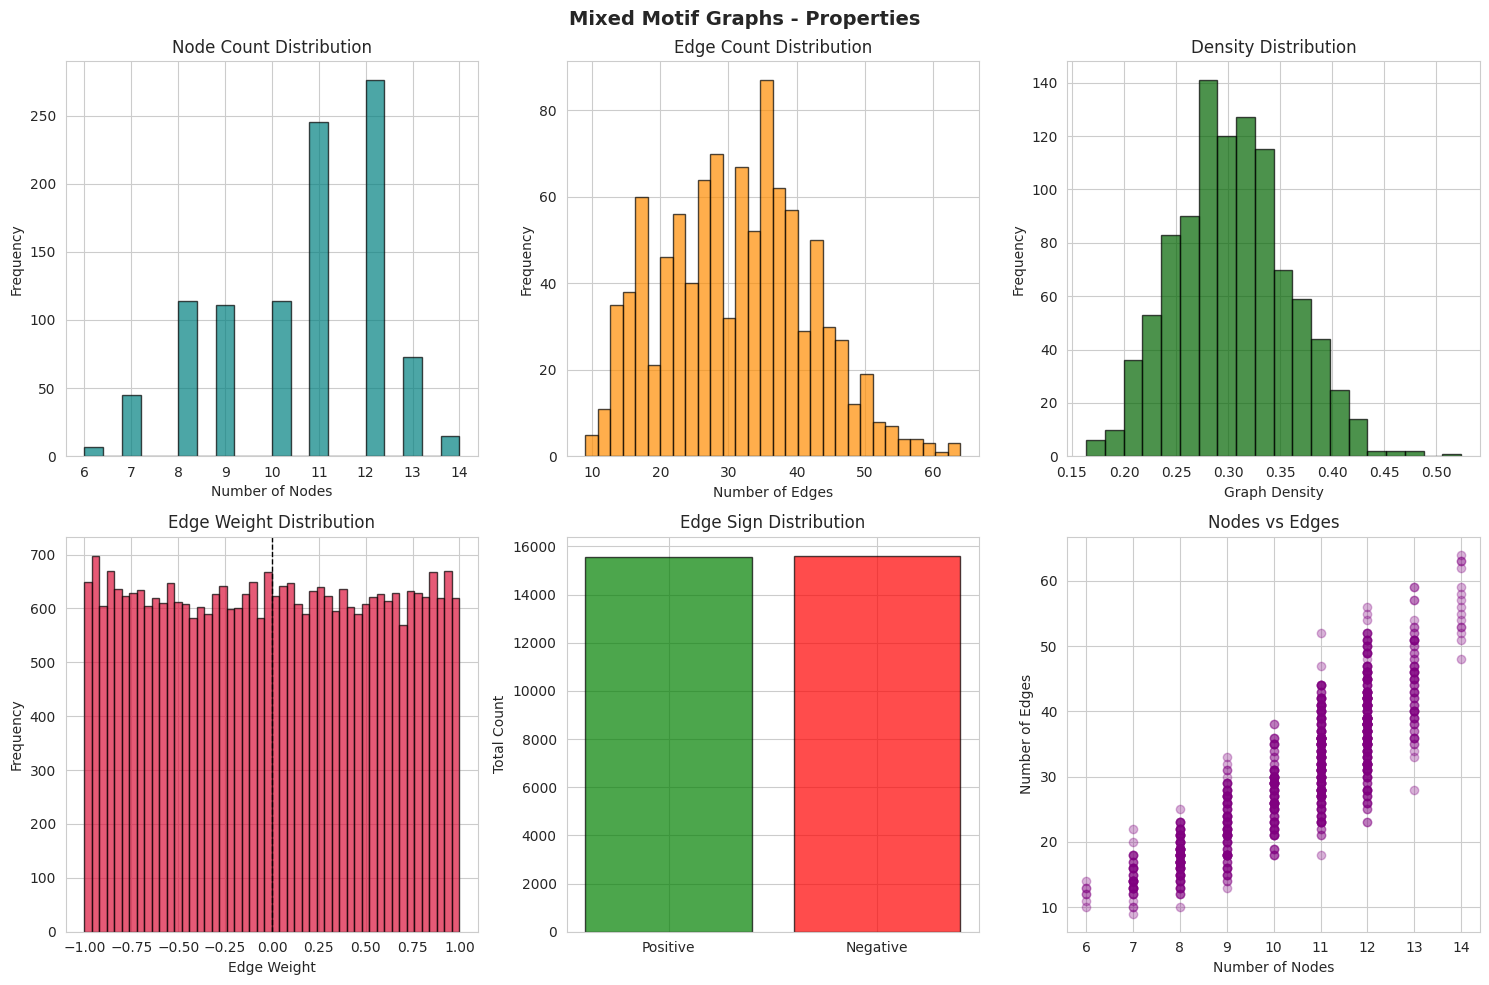

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].hist(mixed_df['num_nodes'], bins=20, edgecolor='black', alpha=0.7, color='teal')
axes[0, 0].set_xlabel('Number of Nodes')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Node Count Distribution')

axes[0, 1].hist(mixed_df['num_edges'], bins=30, edgecolor='black', alpha=0.7, color='darkorange')
axes[0, 1].set_xlabel('Number of Edges')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Edge Count Distribution')

axes[0, 2].hist(mixed_df['density'], bins=20, edgecolor='black', alpha=0.7, color='darkgreen')
axes[0, 2].set_xlabel('Graph Density')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Density Distribution')

all_mixed_weights = [w for p in mixed_properties for w in p['edge_weights']]
axes[1, 0].hist(all_mixed_weights, bins=50, edgecolor='black', alpha=0.7, color='crimson')
axes[1, 0].set_xlabel('Edge Weight')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Edge Weight Distribution')
axes[1, 0].axvline(0, color='black', linestyle='--', linewidth=1)

axes[1, 1].bar(['Positive', 'Negative'], 
               [mixed_df['positive_edges'].sum(), mixed_df['negative_edges'].sum()],
               color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Total Count')
axes[1, 1].set_title('Edge Sign Distribution')

axes[1, 2].scatter(mixed_df['num_nodes'], mixed_df['num_edges'], alpha=0.3, color='purple')
axes[1, 2].set_xlabel('Number of Nodes')
axes[1, 2].set_ylabel('Number of Edges')
axes[1, 2].set_title('Nodes vs Edges')

plt.suptitle('Mixed Motif Graphs - Properties', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

/tmp/ipykernel_800171/2326579487.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(motif_names, rotation=45, ha='right')


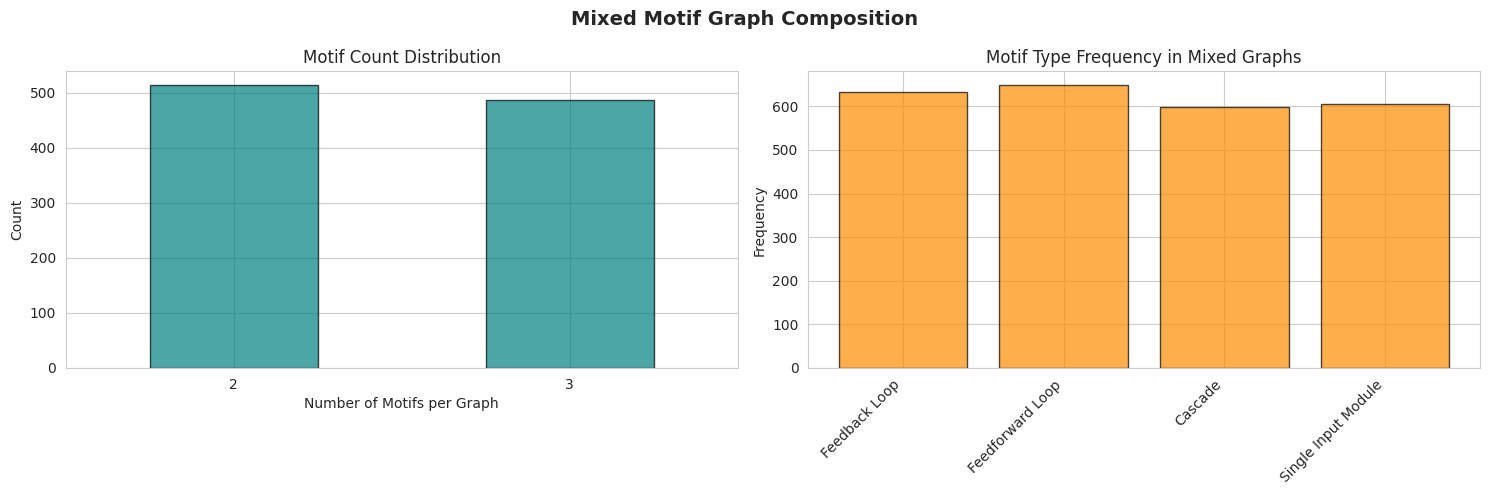

In [24]:
motif_composition = []
for G in mixed_motif_graphs[:1000]:
    if 'motif_composition' in G.graph:
        composition = G.graph['motif_composition']
        motif_composition.append({
            'num_motifs': len(composition),
            'motifs': ', '.join(composition)
        })

composition_df = pd.DataFrame(motif_composition)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

composition_df['num_motifs'].value_counts().sort_index().plot(kind='bar', 
                                                               ax=axes[0], 
                                                               color='teal', 
                                                               edgecolor='black',
                                                               alpha=0.7)
axes[0].set_xlabel('Number of Motifs per Graph')
axes[0].set_ylabel('Count')
axes[0].set_title('Motif Count Distribution')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

all_motif_counts = defaultdict(int)
for G in mixed_motif_graphs[:1000]:
    if 'motif_composition' in G.graph:
        for motif in G.graph['motif_composition']:
            all_motif_counts[motif] += 1

motif_names = [m.replace('_', ' ').title() for m in all_motif_counts.keys()]
motif_counts = list(all_motif_counts.values())

axes[1].bar(motif_names, motif_counts, color='darkorange', edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Frequency')
axes[1].set_title('Motif Type Frequency in Mixed Graphs')
axes[1].set_xticklabels(motif_names, rotation=45, ha='right')

plt.suptitle('Mixed Motif Graph Composition', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

/tmp/ipykernel_800171/3406730926.py:16: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors,


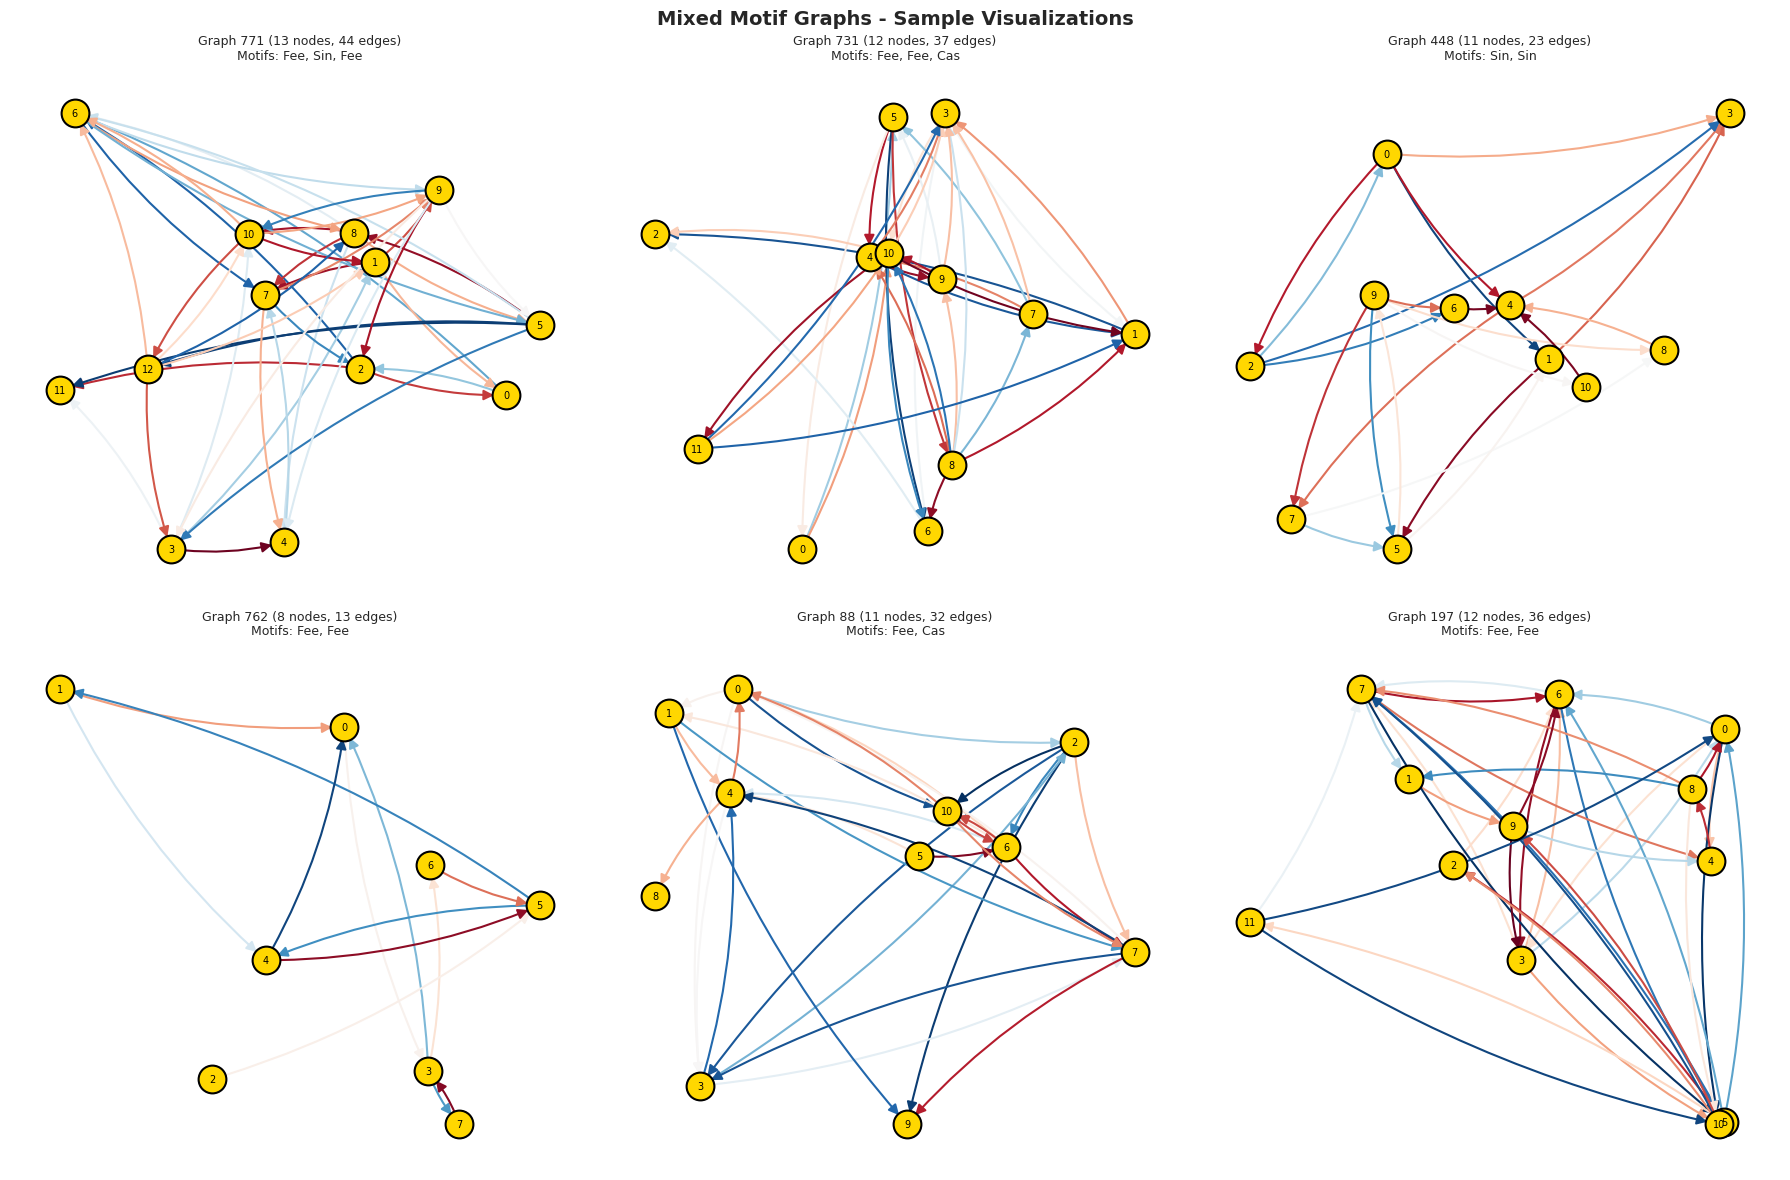

In [25]:
sample_mixed = np.random.choice(len(mixed_motif_graphs), size=min(6, len(mixed_motif_graphs)), replace=False)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, graph_idx in enumerate(sample_mixed):
    G = mixed_motif_graphs[graph_idx]
    
    pos = nx.spring_layout(G, seed=42, k=0.5)
    
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color='gold', 
                          edgecolors='black', linewidths=1.5, ax=axes[idx])
    
    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors, 
                                   edge_cmap=plt.cm.RdBu_r, edge_vmin=-1, edge_vmax=1,
                                   width=1.5, arrows=True, arrowsize=15, 
                                   connectionstyle='arc3,rad=0.1', ax=axes[idx])
    
    nx.draw_networkx_labels(G, pos, font_size=7, ax=axes[idx])
    
    title = f'Graph {graph_idx} ({len(G.nodes())} nodes, {len(G.edges())} edges)'
    if 'motif_composition' in G.graph:
        motifs = ', '.join([m.replace('_', ' ').title()[:3] for m in G.graph['motif_composition']])
        title += f'\nMotifs: {motifs}'
    
    axes[idx].set_title(title, fontsize=9)
    axes[idx].axis('off')

plt.suptitle('Mixed Motif Graphs - Sample Visualizations', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

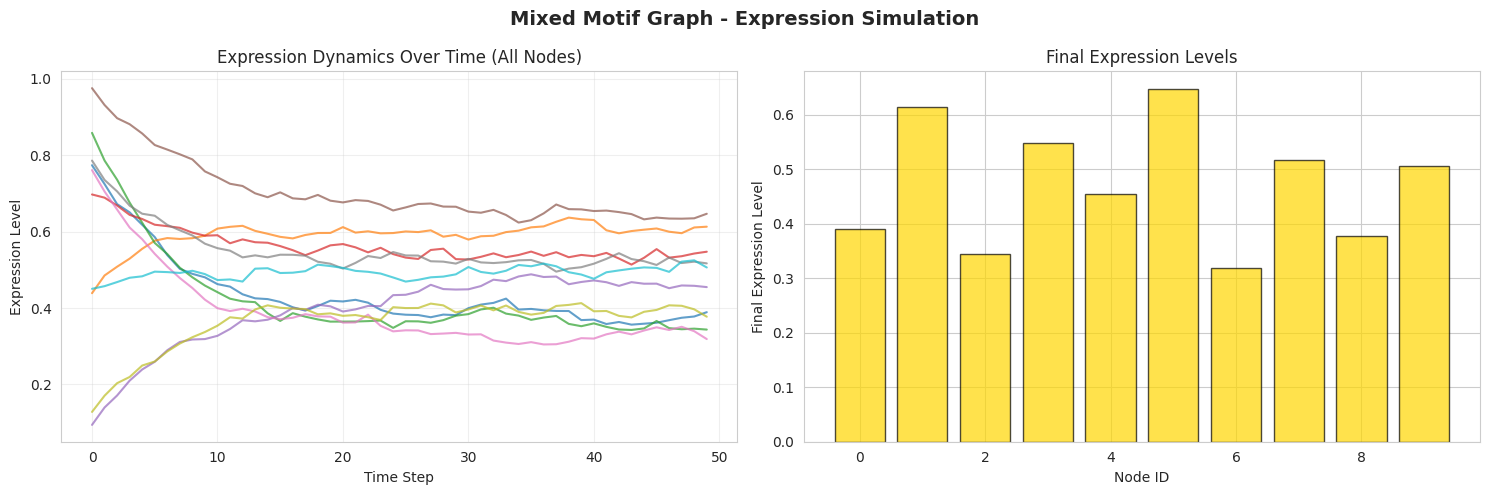

In [26]:
sample_mixed_graph = mixed_motif_graphs[0]
W_mixed = nx.to_numpy_array(sample_mixed_graph, weight='weight')
final_expr_mixed, trajectory_mixed = simulate_expression(W_mixed, steps=50)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for node in range(len(final_expr_mixed)):
    axes[0].plot(trajectory_mixed[:, node], linewidth=1.5, alpha=0.7)
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Expression Level')
axes[0].set_title('Expression Dynamics Over Time (All Nodes)')
axes[0].grid(alpha=0.3)

axes[1].bar(range(len(final_expr_mixed)), final_expr_mixed, color='gold', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Node ID')
axes[1].set_ylabel('Final Expression Level')
axes[1].set_title('Final Expression Levels')

plt.suptitle('Mixed Motif Graph - Expression Simulation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Single vs Mixed Motif Comparison

Direct comparison between single-motif and mixed-motif graph properties.

In [27]:
single_vs_mixed = []

for motif_name, graphs in single_motif_graphs.items():
    for G in graphs[:200]:
        props = extract_graph_properties(G)
        single_vs_mixed.append({
            'type': 'Single',
            'num_nodes': props['num_nodes'],
            'num_edges': props['num_edges'],
            'density': props['density'],
            'mean_weight': props['mean_weight']
        })

for G in mixed_motif_graphs[:200]:
    props = extract_graph_properties(G)
    single_vs_mixed.append({
        'type': 'Mixed',
        'num_nodes': props['num_nodes'],
        'num_edges': props['num_edges'],
        'density': props['density'],
        'mean_weight': props['mean_weight']
    })

svm_df = pd.DataFrame(single_vs_mixed)

/tmp/ipykernel_800171/4169697160.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=svm_df, x='type', y='num_nodes', ax=axes[0, 0], palette='Set2')
/tmp/ipykernel_800171/4169697160.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=svm_df, x='type', y='num_edges', ax=axes[0, 1], palette='Set2')
/tmp/ipykernel_800171/4169697160.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=svm_df, x='type', y='density', ax=axes[1, 0], palette='Set2')
/tmp/ipykernel_800171/4169697160.py:14: FutureWarning: 

Passing `palette` without 

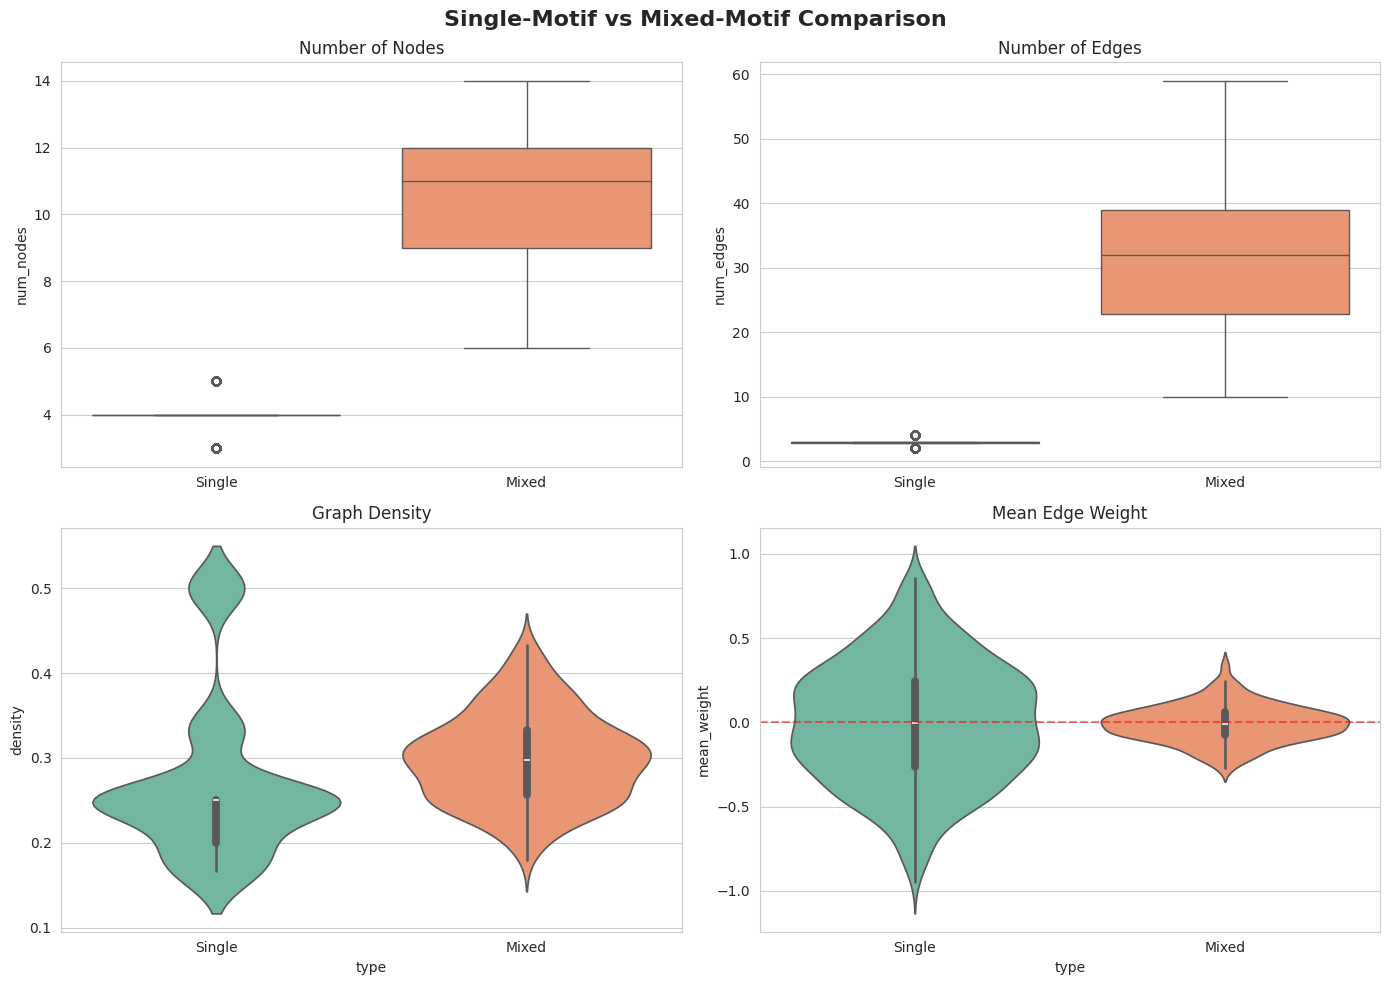

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(data=svm_df, x='type', y='num_nodes', ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('Number of Nodes')
axes[0, 0].set_xlabel('')

sns.boxplot(data=svm_df, x='type', y='num_edges', ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Number of Edges')
axes[0, 1].set_xlabel('')

sns.violinplot(data=svm_df, x='type', y='density', ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Graph Density')

sns.violinplot(data=svm_df, x='type', y='mean_weight', ax=axes[1, 1], palette='Set2')
axes[1, 1].set_title('Mean Edge Weight')
axes[1, 1].axhline(0, color='red', linestyle='--', alpha=0.5)

plt.suptitle('Single-Motif vs Mixed-Motif Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [29]:
print("\nSingle vs Mixed Statistics:")
print(svm_df.groupby('type').agg({
    'num_nodes': ['mean', 'std', 'min', 'max'],
    'num_edges': ['mean', 'std', 'min', 'max'],
    'density': ['mean', 'std'],
    'mean_weight': ['mean', 'std']
}).round(4))


Single vs Mixed Statistics:
       num_nodes                 num_edges                  density          \
            mean     std min max      mean      std min max    mean     std   
type                                                                          
Mixed    10.6650  1.7772   6  14   31.3300  10.5231  10  59  0.2995  0.0527   
Single    3.9075  0.6016   3   5    2.8888   0.6139   2   4  0.2705  0.0946   

       mean_weight          
              mean     std  
type                        
Mixed      -0.0083  0.1112  
Single     -0.0046  0.3590  


---
# Expression Dynamics Comparison

Compare simulated expression patterns across motif types.

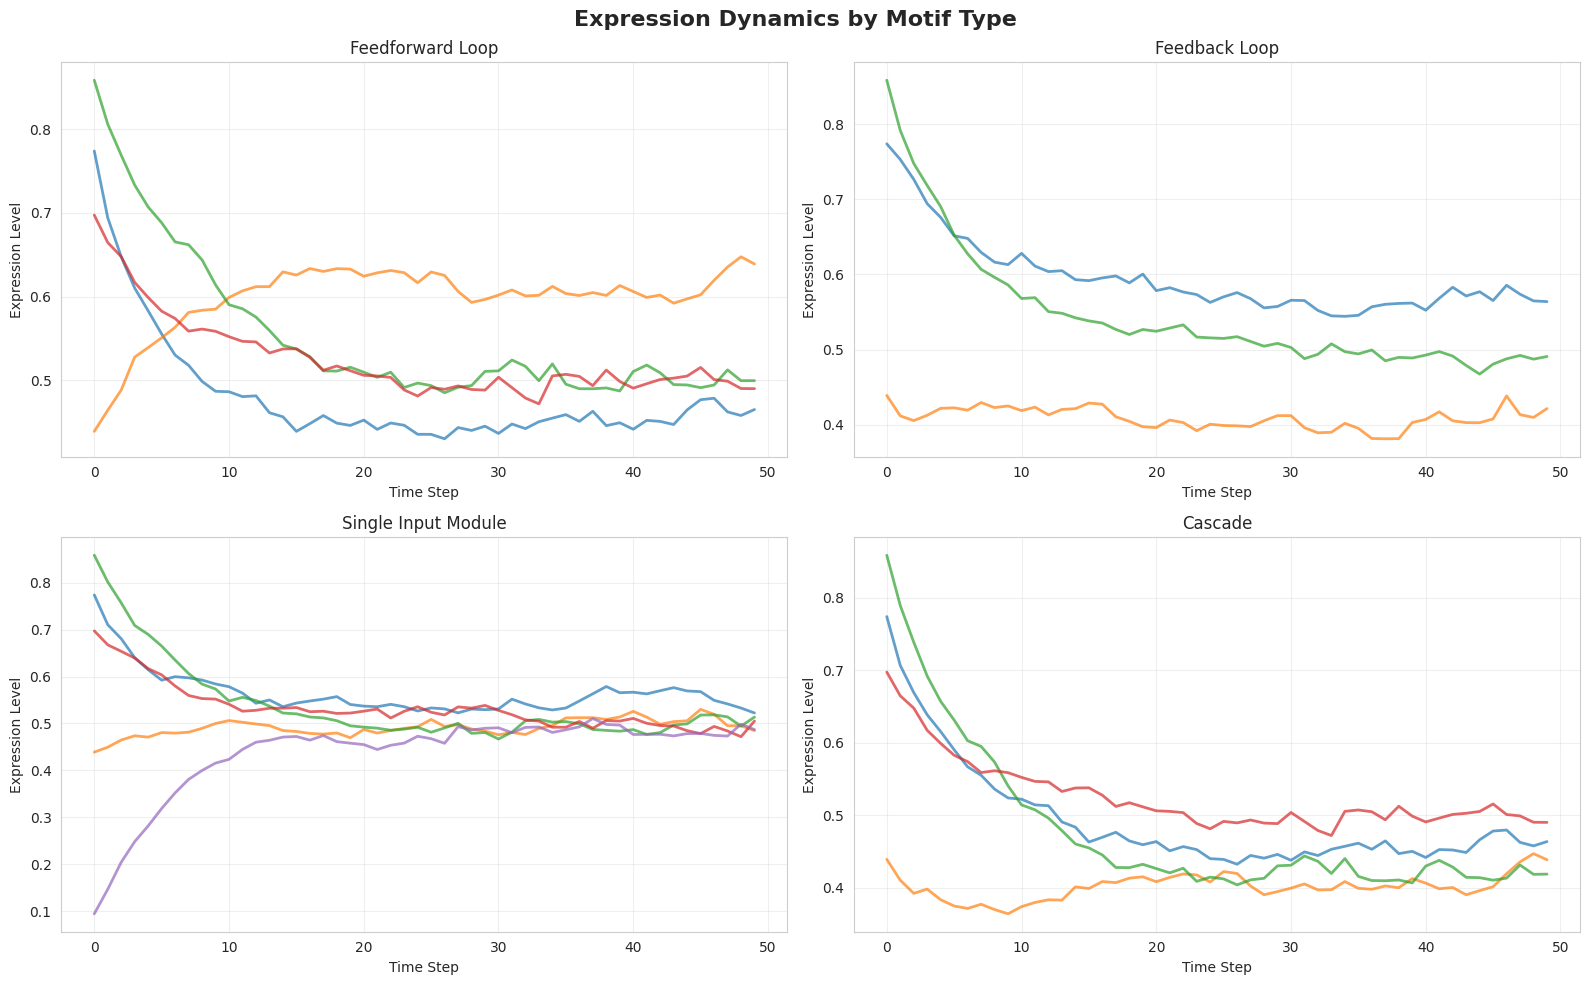

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, motif in enumerate(motif_types):
    sample_G = single_motif_graphs[motif][0]
    W = nx.to_numpy_array(sample_G, weight='weight')
    _, traj = simulate_expression(W, steps=50)
    
    for node in range(traj.shape[1]):
        axes[idx].plot(traj[:, node], linewidth=2, alpha=0.7)
    
    axes[idx].set_xlabel('Time Step')
    axes[idx].set_ylabel('Expression Level')
    axes[idx].set_title(f'{motif.replace("_", " ").title()}')
    axes[idx].grid(alpha=0.3)

plt.suptitle('Expression Dynamics by Motif Type', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

/tmp/ipykernel_800171/1774014580.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=variance_df, x='motif', y='temporal_variance', ax=axes[0], palette='muted')
/tmp/ipykernel_800171/1774014580.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_800171/1774014580.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=variance_df, x='motif', y='final_variance', ax=axes[1], palette='muted')
/tmp/ipykernel_800171/1774014580.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i

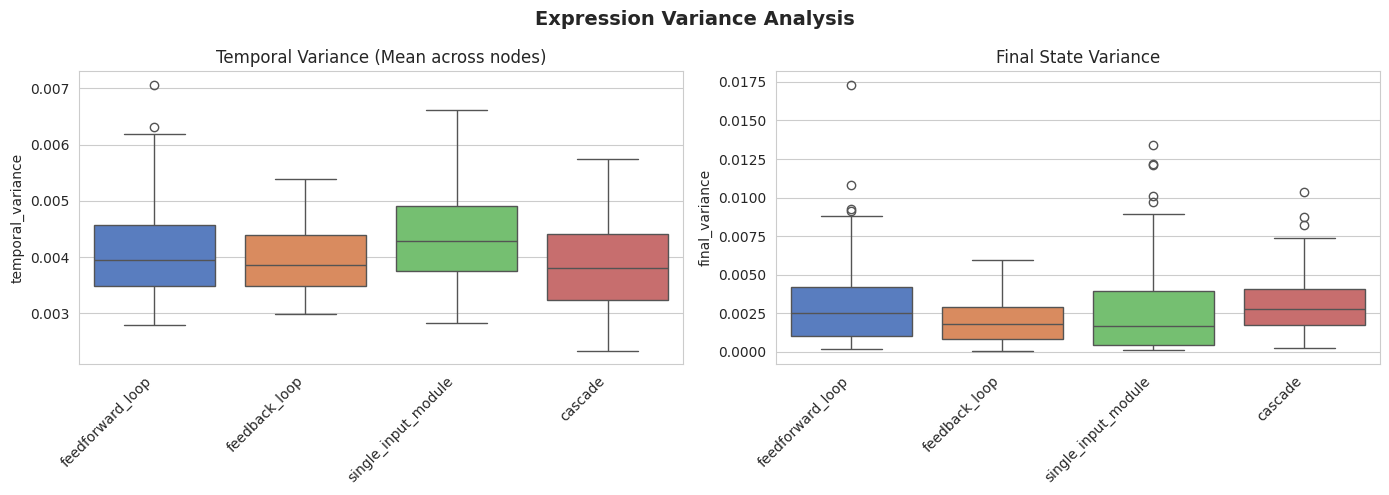

In [31]:
variance_data = []

for motif_name, graphs in single_motif_graphs.items():
    for G in graphs[:100]:
        W = nx.to_numpy_array(G, weight='weight')
        _, traj = simulate_expression(W, steps=50)
        
        temporal_variance = np.var(traj, axis=0).mean()
        final_variance = np.var(traj[-1])
        
        variance_data.append({
            'motif': motif_name,
            'temporal_variance': temporal_variance,
            'final_variance': final_variance
        })

variance_df = pd.DataFrame(variance_data)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=variance_df, x='motif', y='temporal_variance', ax=axes[0], palette='muted')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title('Temporal Variance (Mean across nodes)')
axes[0].set_xlabel('')

sns.boxplot(data=variance_df, x='motif', y='final_variance', ax=axes[1], palette='muted')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title('Final State Variance')
axes[1].set_xlabel('')

plt.suptitle('Expression Variance Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Network Topology Analysis

Analysis of graph-theoretic properties like degree distributions and centrality.

In [32]:
degree_data = []

for motif_name, graphs in single_motif_graphs.items():
    for G in graphs[:200]:
        for node in G.nodes():
            degree_data.append({
                'motif': motif_name,
                'in_degree': G.in_degree(node),
                'out_degree': G.out_degree(node),
                'total_degree': G.in_degree(node) + G.out_degree(node)
            })

degree_df = pd.DataFrame(degree_data)

/tmp/ipykernel_800171/3855734115.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=degree_df, x='motif', y='in_degree', ax=axes[0], palette='pastel')
/tmp/ipykernel_800171/3855734115.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_800171/3855734115.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=degree_df, x='motif', y='out_degree', ax=axes[1], palette='pastel')
/tmp/ipykernel_800171/3855734115.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after se

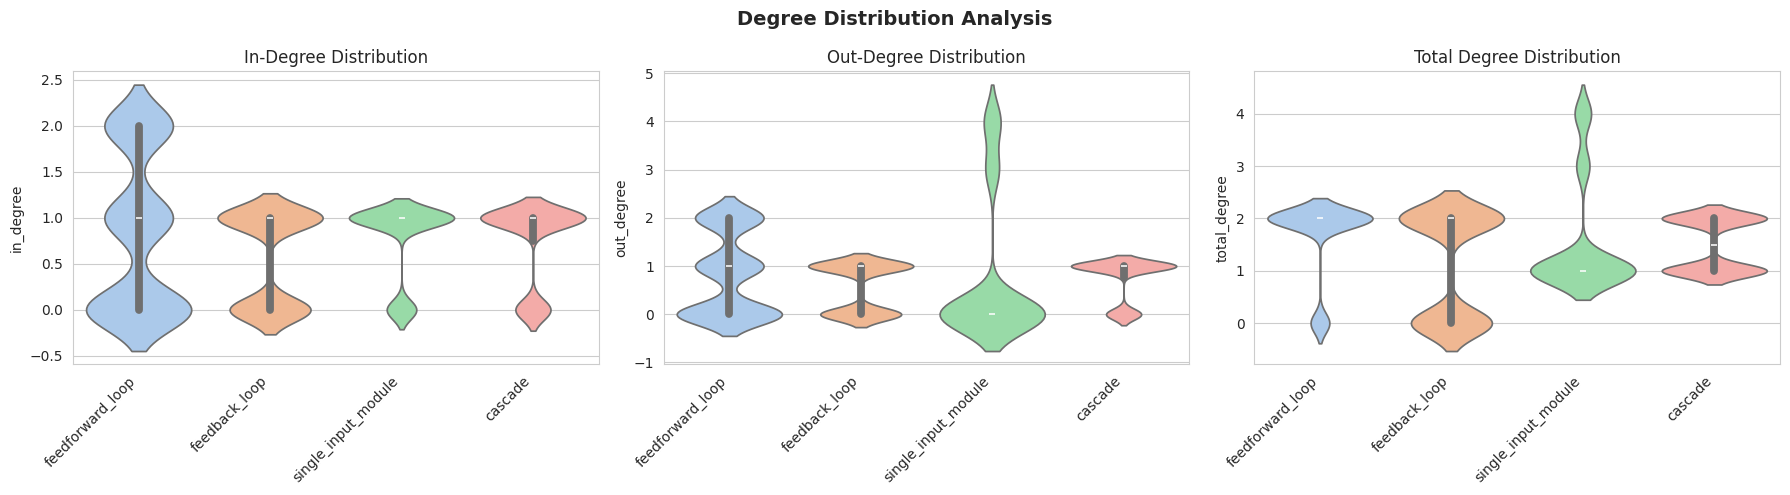

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.violinplot(data=degree_df, x='motif', y='in_degree', ax=axes[0], palette='pastel')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title('In-Degree Distribution')
axes[0].set_xlabel('')

sns.violinplot(data=degree_df, x='motif', y='out_degree', ax=axes[1], palette='pastel')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title('Out-Degree Distribution')
axes[1].set_xlabel('')

sns.violinplot(data=degree_df, x='motif', y='total_degree', ax=axes[2], palette='pastel')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
axes[2].set_title('Total Degree Distribution')
axes[2].set_xlabel('')

plt.suptitle('Degree Distribution Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [34]:
print("\nDegree Statistics by Motif:")
print(degree_df.groupby('motif').agg({
    'in_degree': ['mean', 'std', 'max'],
    'out_degree': ['mean', 'std', 'max'],
    'total_degree': ['mean', 'std', 'max']
}).round(4))


Degree Statistics by Motif:
                    in_degree             out_degree             total_degree  \
                         mean     std max       mean     std max         mean   
motif                                                                           
cascade                0.7500  0.4333   1     0.7500  0.4333   1       1.5000   
feedback_loop          0.5650  0.4961   1     0.5650  0.4961   1       1.1299   
feedforward_loop       0.8487  0.8338   2     0.8487  0.8338   2       1.6973   
single_input_module    0.7805  0.4142   1     0.7805  1.4907   4       1.5609   

                                 
                        std max  
motif                            
cascade              0.5003   2  
feedback_loop        0.9922   2  
feedforward_loop     0.7173   2  
single_input_module  1.0835   4  


---
# Summary and Conclusions

Final summary of the virtual graph dataset.

In [35]:
summary = {
    'Total Graphs': total_single + total_mixed,
    'Single-Motif Graphs': total_single,
    'Mixed-Motif Graphs': total_mixed,
    'Motif Types': len(motif_types),
}

for motif in motif_types:
    summary[f'{motif} count'] = len(single_motif_graphs[motif])

summary_df = pd.DataFrame([summary]).T
summary_df.columns = ['Value']

print("="*50)
print("VIRTUAL GRAPH DATASET SUMMARY")
print("="*50)
print(summary_df)
print("="*50)

VIRTUAL GRAPH DATASET SUMMARY
                           Value
Total Graphs                5000
Single-Motif Graphs         4000
Mixed-Motif Graphs          1000
Motif Types                    4
feedforward_loop count      1000
feedback_loop count         1000
single_input_module count   1000
cascade count               1000
